In [1]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

C:\Users\munu2\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\munu2\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\munu2\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\munu2\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [3]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.5,28.6,2644.6,539.6,1427.8,501.3,3.9,2.0
std,2.1,2.0,12.5,2217.3,429.3,1177.2,391.6,1.9,1.0
min,32.5,-124.3,1.0,8.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1453.0,296.0,786.0,281.0,2.6,1.5
50%,34.2,-118.5,29.0,2122.0,433.0,1163.0,408.0,3.5,1.9
75%,37.7,-118.0,37.0,3148.0,646.0,1720.2,603.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,35682.0,6082.0,15.0,41.3


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.6,2641.3,538.8,1433.8,501.1,3.9,2.0
std,2.1,2.0,12.8,2087.9,402.1,1074.2,367.0,1.9,1.4
min,32.5,-124.3,1.0,2.0,2.0,6.0,2.0,0.5,0.1
25%,33.9,-121.8,18.0,1474.8,298.0,797.8,283.0,2.6,1.5
50%,34.3,-118.5,29.0,2150.0,435.0,1178.5,410.0,3.6,1.9
75%,37.7,-118.0,37.0,3156.2,655.2,1722.0,610.0,4.8,2.3
max,41.9,-114.6,52.0,28258.0,4335.0,12203.0,3933.0,15.0,55.2


Training targets summary:


,median_house_value
count,12000.0
mean,207.1
std,116.3
min,15.0
25%,118.8
50%,179.9
75%,264.7
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,207.8
std,115.3
min,15.0
25%,121.4
50%,181.5
75%,265.7
max,500.0


In [4]:
def construct_feature_columns(input_features):
    return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])

In [5]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural net regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    features = {key:np.array(value) for key, value in dict(features).items()}
    
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(10000)
    
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [8]:
def train_nn_regression_model(
    learning_rate, steps, batch_size, hidden_units, training_examples, training_targets, validation_examples, validation_targets):
    
    periods = 10
    steps_per_period = steps / periods
    
    mOptimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate) # optimizer 및 학습률 설정
    mOptimizer = tf.contrib.estimator.clip_gradients_by_norm(mOptimizer, 5.0)
    
    dnn_regressor = tf.estimator.DNNRegressor(
        feature_columns = construct_feature_columns(training_examples),
        hidden_units = hidden_units,
        optimizer = mOptimizer
    )
    
    training_input_fn = lambda: my_input_fn(training_examples,
                                           training_targets["median_house_value"],
                                           batch_size = batch_size)
    
    predict_training_input_fn = lambda: my_input_fn(training_examples,
                                           training_targets["median_house_value"],
                                            num_epochs=1, shuffle=False)
    
    predict_validation_input_fn = lambda: my_input_fn(validation_examples,
                                           validation_targets["median_house_value"],
                                           num_epochs=1, shuffle=False)
    training_rmse = []
    validation_rmse = []
    
    for period in range(0, periods):
        dnn_regressor.train(
            input_fn = training_input_fn,
            steps = steps_per_period
        )
    
         # Take a break and compute predictions.
        training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
        validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        
        # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets))
        
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
 

      # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
    print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

    return dnn_regressor

  period 00 : 216.88


  period 01 : 196.24


  period 02 : 176.72


  period 03 : 158.75


  period 04 : 142.90


  period 05 : 130.88


  period 06 : 123.31


  period 07 : 118.35


  period 08 : 117.37


  period 09 : 116.89
Final RMSE (on training data):   116.89
Final RMSE (on validation data): 116.00


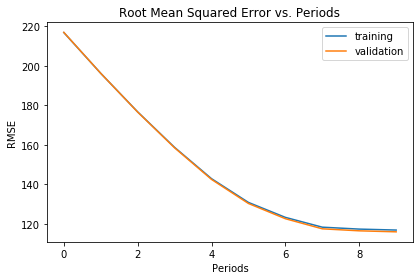

In [26]:
dnn_regressor = train_nn_regression_model(
    learning_rate= 0.1,
    steps=500,
    batch_size=10,
    hidden_units=[50, 25, 15, 7, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [27]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")

# Choose the last 5000 (out of 17000) examples for validation.
test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

display.display(test_examples.describe())
display.display(test_targets.describe())

predict_test_input_fn = lambda: my_input_fn(test_examples, test_targets["median_house_value"], num_epochs=1, shuffle=False)

test_predictions = dnn_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])
        
test_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(test_predictions, test_targets))
        
print(" test_rmse : %0.2f" % (test_root_mean_squared_error))

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0
mean,35.6,-119.6,28.8,2599.6,530.0,1402.8,489.9,3.8,2.0
std,2.1,2.0,12.6,2155.6,415.7,1030.5,365.4,1.9,1.1
min,32.6,-124.2,1.0,6.0,2.0,5.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1401.0,291.0,780.0,273.0,2.5,1.5
50%,34.3,-118.5,29.0,2106.0,437.0,1155.0,409.5,3.5,1.9
75%,37.7,-118.0,37.0,3129.0,636.0,1742.8,597.2,4.7,2.3
max,41.9,-114.5,52.0,30450.0,5419.0,11935.0,4930.0,15.0,33.8


,median_house_value
count,3000.0
mean,205.8
std,113.1
min,22.5
25%,121.2
50%,177.6
75%,264.0
max,500.0


 test_rmse : 113.62
